In [1]:
import sympy as sp
from sympy import Piecewise, DiracDelta
from sympy.core.numbers import pi, oo
from IPython.display import display
from latex2sympy2 import latex2sympy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget


In [2]:
def odedopri(f,  x0,  y0,  x1,  tol,  hmax,  hmin,  maxiter, args=()):
    a21 = (1.0/5.0)
    a31 = (3.0/40.0)
    a32 = (9.0/40.0)
    a41 = (44.0/45.0)
    a42 = (-56.0/15.0)
    a43 = (32.0/9.0)
    a51 = (19372.0/6561.0)
    a52 = (-25360.0/2187.0)
    a53 = (64448.0/6561.0)
    a54 = (-212.0/729.0)
    a61 = (9017.0/3168.0)
    a62 = (-355.0/33.0)
    a63 = (46732.0/5247.0)
    a64 = (49.0/176.0)
    a65 = (-5103.0/18656.0)
    a71 = (35.0/384.0)
    a72 = (0.0)
    a73 = (500.0/1113.0)
    a74 = (125.0/192.0)
    a75 = (-2187.0/6784.0)
    a76 = (11.0/84.0)
    c2 = (1.0 / 5.0)
    c3 = (3.0 / 10.0)
    c4 = (4.0 / 5.0)
    c5 = (8.0 / 9.0)
    c6 = (1.0)
    c7 = (1.0)
    b1 = (35.0/384.0)
    b2 = (0.0)
    b3 = (500.0/1113.0)
    b4 = (125.0/192.0)
    b5 = (-2187.0/6784.0)
    b6 = (11.0/84.0)
    b7 = (0.0)
    b1p = (5179.0/57600.0)
    b2p = (0.0)
    b3p = (7571.0/16695.0)
    b4p = (393.0/640.0)
    b5p = (-92097.0/339200.0)
    b6p = (187.0/2100.0)
    b7p = (1.0/40.0)
    x = x0
    y = y0
    h = hmax
    X = np.zeros(maxiter)
    X[0] = x0
    Y = np.zeros((maxiter, len(y0)))
    Y[0] = y0
    
    #We need a special step counter because the ODE dormand prince 
    #method will do a step again with a smaller step size if the error is too large
    step = 1
    for i in range(maxiter):
       # /* Compute the function values */
       K1 = f(x,       y, *args)
       K2 = f(x + c2*h, y+h*(a21*K1), *args)
       K3 = f(x + c3*h, y+h*(a31*K1+a32*K2), *args)
       K4 = f(x + c4*h, y+h*(a41*K1+a42*K2+a43*K3), *args)
       K5 = f(x + c5*h, y+h*(a51*K1+a52*K2+a53*K3+a54*K4), *args)
       K6 = f(x + h, y+h*(a61*K1+a62*K2+a63*K3+a64*K4+a65*K5), *args)
       K7 = f(x + h, y+h*(a71*K1+a72*K2+a73*K3+a74*K4+a75*K5+a76*K6), *args)
       error = abs((b1-b1p)*K1+(b3-b3p)*K3+(b4-b4p)*K4+(b5-b5p)*K5 +
                   (b6-b6p)*K6+(b7-b7p)*K7)
       #Error in X controls tolerance
       error = max(error)
       # error control
       if error != 0.0:
           delta = 0.84 * pow(tol / error, (1.0/5.0))
       else:
           delta = np.inf
       if (error < tol):
          x = x + h
          X[step] = x
          y = y + h * (b1*K1+b3*K3+b4*K4+b5*K5+b6*K6)
          Y[step, :] = y
          step+=1
       if (delta <= 0.1):
          h = h * 0.1
       elif (delta >= 4.0):
          h = h * 4.0
       else:
          h = delta * h
       if (h > hmax):
          h = hmax
       if (x >= x1):
          print('reached end')
          break
       elif (x + h > x1):
          h = x1 - x
       elif (h < hmin):
          print('Below hmin')
          break
    return X, Y, step

In [3]:
def trajectory_equation_of_motion(z, x, phi_hat_lambda, dphi_hat_lambda):
    
    p = np.sqrt(1+x[1]**2+x[3]**2) #obtain slope of ray
    phi_hat = phi_hat_lambda(x[0], x[2], z) #evaluate potential
    dphi_hat_x, dphi_hat_y, dphi_hat_z = dphi_hat_lambda(x[0], x[2], z) #evaluate the efield
    
    return np.array([x[1], (p**2)/(2*phi_hat)*(dphi_hat_x-x[1]*dphi_hat_z), x[3], (p**2)/(2*phi_hat)*(dphi_hat_y-x[3]*dphi_hat_z)]) #evaluate the velocities and accelerations, [vx, ax, vy, ay]


def linear_trajectory_equation_of_motion(z, x, dphi_ax, ddphi_ax, phi_hat):
    gamma = 1
    
    return np.array([x[1], -(gamma*dphi_ax(z))/(2*phi_hat(z))*x[1]-gamma*(ddphi_ax(z))/(4*phi_hat(z))*x[0], 0, 0]) #evaluate the velocities and accelerations, [vx, ax, vy, ay]

In [4]:
e = -1#.60217662e-19 #unit C
m = 1#9.10938356e-31 #unit kg
c_l = 1#2.99792458e8 #unit m/s
h = 1
eps = 0#abs(e)/(2*m*c_l**2)

x_sym, y_sym, z_sym = sp.symbols('x, y, z')

phi_0 = 5

k = np.sqrt(0.5)
a = 0.025
phi = phi_0*((k**2)/(1+(z_sym /a)**2))
phi_hat = phi*(1+eps*(phi))

#Include the initial potential of the electron from the gun. 
phi_hat_electron = phi_0 - phi_hat

#Get E field function. Notice there is no negative sign, as the way hawkes uses phi_hat, there is no minus before it (Equation 3.22).
dphi_hat_electron_dx = -(1/2)*phi_hat_electron.diff(z_sym, 2)*(1+2*eps*phi_hat)*x_sym
dphi_hat_electron_dy = 0
dphi_hat_electron_dz = phi_hat_electron.diff(z_sym, 1)*(1+2*eps*phi_hat)

phi_lens = sp.lambdify([x_sym, y_sym, z_sym], phi_hat_electron, 'numpy')
dphi_lens = sp.lambdify([x_sym, y_sym, z_sym], [dphi_hat_electron_dx, dphi_hat_electron_dy, dphi_hat_electron_dz], 'numpy')

x0 = np.array([0, 1e-7, 0, 0]) #x, x', y, y'
z0 = -0.5
zF = 0.8172874918

tol = 1e-12 #error tolerance in the calculation (error in force or velocity on one axis is no larger than tolerance)
max_step_size = 1e-4 #m
min_step_size = 1e-15 #m
z_out, x_out, steps = odedopri(trajectory_equation_of_motion,  z0,  x0,  zF,  tol ,  max_step_size,  min_step_size,  100000, args=(phi_lens, dphi_lens))

x, y, z = x_out[:steps, 0], x_out[:steps, 2], z_out[:steps]
wavelengths = h/(2*abs(e)*m*phi_lens(x, y, z))**(1/2)

#Make a list of wavelengths that are normalised so we can color them. 
wavelengths_norm = (wavelengths-min(wavelengths))/(max(wavelengths)-min(wavelengths))
colors = plt.cm.jet(wavelengths_norm)

reached end


X positional deflection (m): 3.2865951103323758e-18
Y positional deflection (m): 0.0


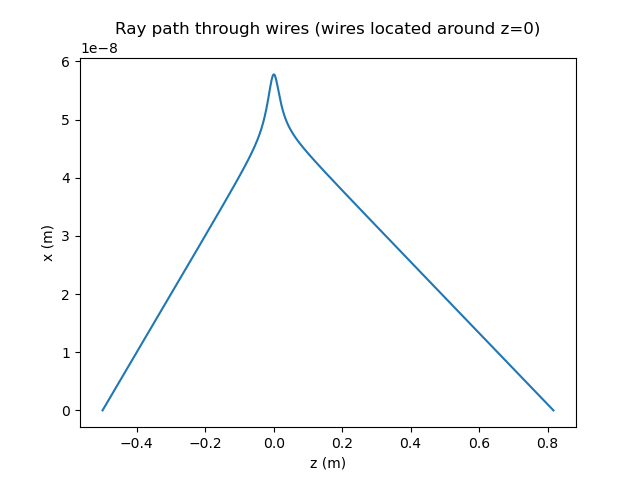

In [5]:
plt.figure()
plt.plot(z_out[:steps], x_out[:steps, 0])
plt.title('Ray path through wires (wires located around z=0)')
plt.xlabel('z (m)')
plt.ylabel('x (m)')

print('X positional deflection (m):', abs(x_out[0, 0]-x_out[steps-1, 0]))
print('Y positional deflection (m):', abs(x_out[0, 2]-x_out[steps-1, 2]))


In [6]:
phi_ax = phi_0-phi_0*((k**2)/(1+(z_sym /a)**2))
dphi_ax = phi_ax.diff(z_sym , 1)
ddphi_ax = phi_ax.diff(z_sym , 2)
phi_hat = phi_ax

phi_hat = sp.lambdify([z_sym], phi_hat, 'numpy')
dphi_ax = sp.lambdify([z_sym], dphi_ax, 'numpy')
ddphi_ax = sp.lambdify([z_sym], ddphi_ax, 'numpy')

z_out, x_out, steps = odedopri(linear_trajectory_equation_of_motion,  z0,  x0,  zF,  tol,  max_step_size,  min_step_size,  100000, args=(dphi_ax, ddphi_ax, phi_hat))

plt.plot(z_out[:steps], x_out[:steps, 0])
plt.title('Ray path through wires (wires located around z=0)')
plt.xlabel('z (m)')
plt.ylabel('x (m)')

print('X positional deflection (m):', abs(x_out[0, 0]-x_out[steps-1, 0]))
print('Y positional deflection (m):', abs(x_out[0, 2]-x_out[steps-1, 2]))

reached end
X positional deflection (m): 3.2862790263641847e-18
Y positional deflection (m): 0.0


4.10024262732876


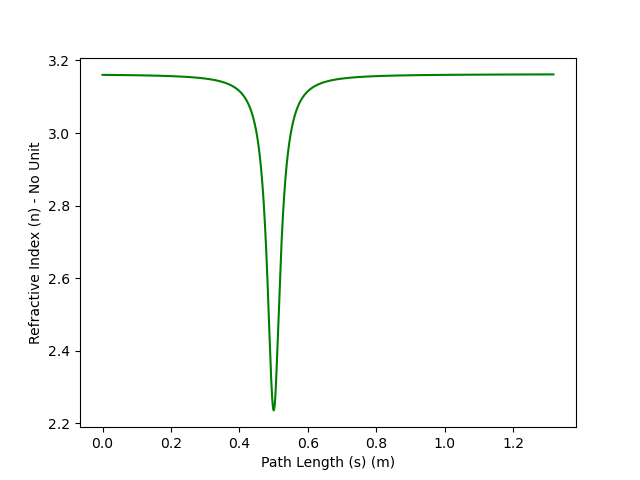

In [7]:
from scipy.integrate import simpson
def optical_path_length(x, y, z, phi_hat_lambda):
    
    deltax, deltay, deltaz = np.diff(x), np.diff(y), np.diff(z) #get the differences between each coordinate
    s = np.cumsum(np.pad(np.sqrt(deltax**2+deltay**2+deltaz**2), (1, 0), "constant")) #path length calculation, with 0 appended to the start
    n = np.sqrt(2*phi_hat_lambda(z))
    opl_n = simpson(n, s)
    
    return s, n, opl_n

s, n, opl_n = optical_path_length(x_out[:steps, 0], x_out[:steps, 2], z_out[:steps], phi_hat)
print(opl_n)

plt.figure()
plt.xlabel('Path Length (s) (m)')
plt.ylabel('Refractive Index (n) - No Unit')
plt.plot(s, n, '-g')

In [8]:
#Calculate optical path length of ray that has not been through the wire, and still has the original wavelength
z_starting_at_0 = z+abs(z[0])
#print(z_starting_at_0)
opl_one = abs(zF)*(1/wavelengths[0])
print(opl_one)
print(opl_n)
''
print(wavelengths)
phase_difference = ((2*np.pi)*(opl_n-opl_one))/wavelengths[0]
print(phase_difference)

2.5828781966314103
4.10024262732876
[0.3164251  0.31642518 0.31642526 ... 0.31630173 0.31630171 0.3163017 ]
30.129979874938382


(0.0, 2.5)

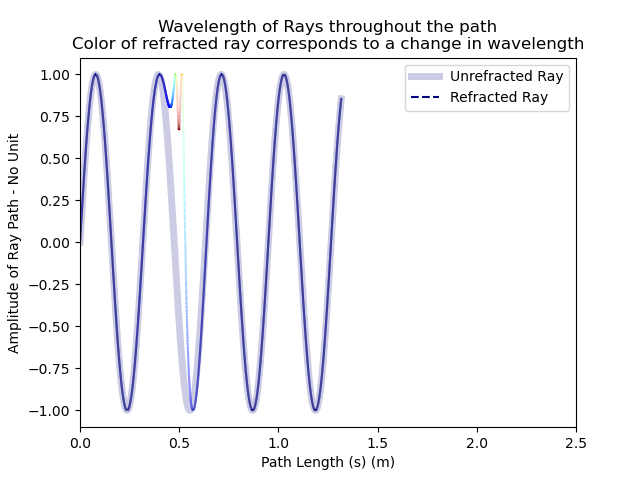

In [9]:
plt.figure()
z0 = np.linspace(z_starting_at_0[0], z_starting_at_0[-1], 1000)
plt.plot(z0, np.sin(2 * np.pi * 1/wavelengths[0] * z0 ), color = colors[0], linewidth = 5, alpha = 0.2, label = 'Unrefracted Ray')
plt.plot([], [], '--', label = 'Refracted Ray', color = colors[0])
plt.xlabel('Path Length (s) (m)')
plt.ylabel('Amplitude of Ray Path - No Unit')
plt.title("Wavelength of Rays throughout the path" 
          "\n"
          "Color of refracted ray corresponds to a change in wavelength")

for idx, wavelength in enumerate(wavelengths[:-1]):
    s_idx = np.linspace(s[idx], s[idx+1], 100)
    plt.plot(s_idx, np.sin(2 * np.pi * 1/wavelengths[idx] * s_idx), color = colors[idx], linestyle = '--')
    
plt.legend()
plt.xlim([0, 2.5])